# 탐색적 데이터 분석 결과

**설명 파일 :** [03_탐색적데이터분석.md](03_탐색적데이터분석.md)

## Step 1. 사전 설정

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import warnings

# 파일 위치 사전 정의
warnings.filterwarnings("ignore")

SAMPLING_DATA_DIR = './data/external'

# 한글 폰트 설정
fe = fm.FontEntry(
fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

print("모듈 import 완료")

모듈 import 완료


## Step 2. 시계열 분석

In [2]:
# 1. 데이터 로드 (연도별 파일 모두 읽기)

data_files = {
    'sampled_2022.csv',
    'sampled_2023.csv',
    'sampled_2024.csv',
    'sampled_2025.csv'
}

dfs = []
for f in data_files:
    path = os.path.join(SAMPLING_DATA_DIR, f)
    if os.path.exists(path):
        df_temp = pd.read_csv(path, usecols=['ta_ymd', 'amt', 'cnt', 'day', 'hour'])
        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

df['date'] = pd.to_datetime(df['ta_ymd'], format='%Y%m%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


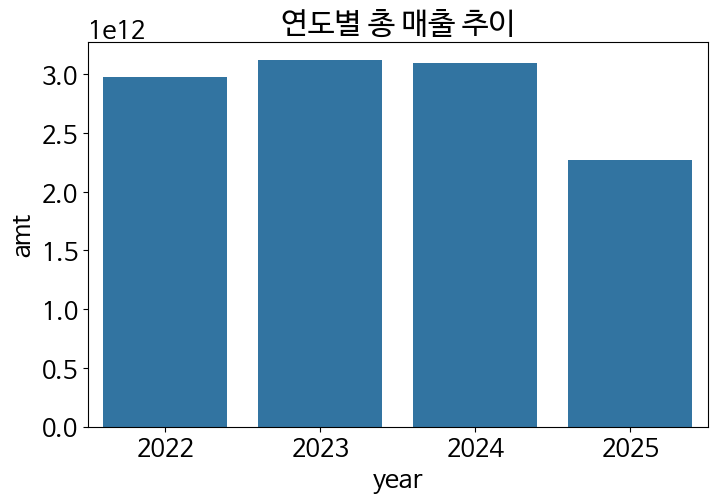

In [3]:
# [시각화 1] 연도별 매출 추이
yearly = df.groupby('year')['amt'].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=yearly, x='year', y='amt')
plt.title('연도별 총 매출 추이')
plt.show()

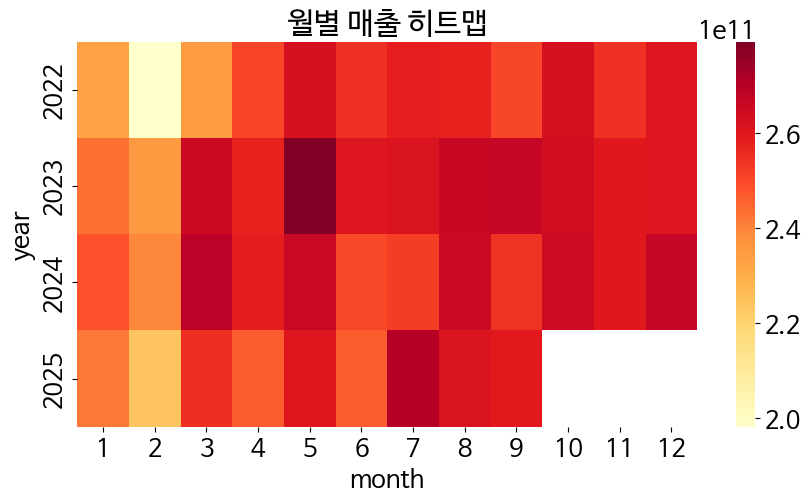

In [7]:
# [시각화 2] 월별 계절성 (히트맵)
pivot = df.groupby(['year', 'month'])['amt'].sum().reset_index().pivot(index='year', columns='month', values='amt')
plt.figure(figsize=(10, 5))
sns.heatmap(pivot, cmap='YlOrRd')
plt.title('월별 매출 히트맵')
plt.show()

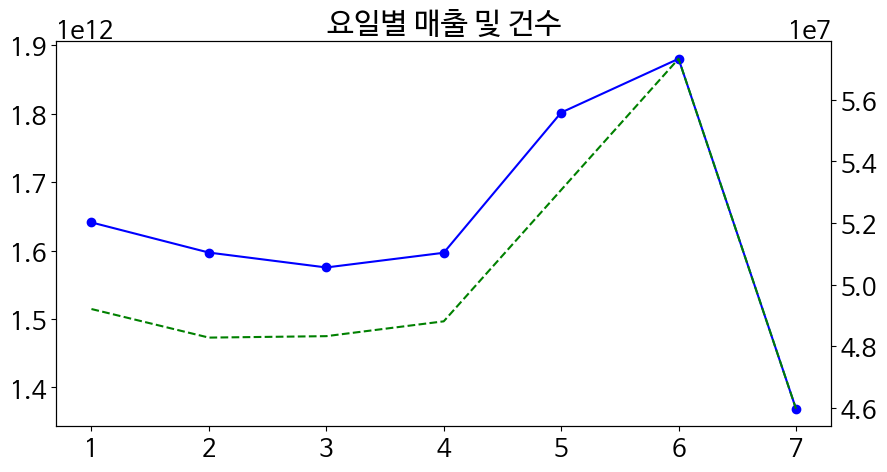

In [6]:
# [시각화 3] 요일별 패턴
hourly = df.groupby('day')[['amt', 'cnt']].sum().reset_index()
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(hourly['day'], hourly['amt'], color='blue', marker='o', label='매출')
ax2 = ax1.twinx()
ax2.plot(hourly['day'], hourly['cnt'], color='green', linestyle='--', label='건수')
plt.title('요일별 매출 및 건수')
plt.show()

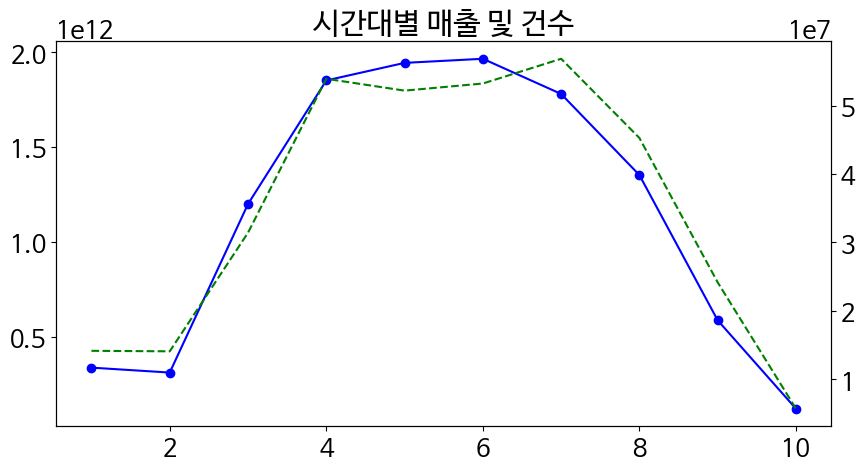

In [ ]:
# [시각화 4] 시간대별 패턴
hourly = df.groupby('hour')[['amt', 'cnt']].sum().reset_index()
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(hourly['hour'], hourly['amt'], color='blue', marker='o', label='매출')
ax2 = ax1.twinx()
ax2.plot(hourly['hour'], hourly['cnt'], color='green', linestyle='--', label='건수')
plt.title('시간대별 매출 및 건수')
plt.show()

분석 포인트

- 연도별 성장 : 2022년 대비 2024년 매출 상승 (코로나 엔데믹 효과 확인)
- 계절성 확인 : 연말, 가정의 달, 휴가철 등과 다른 달 매출 비교
- 요일별 확인 : 주말 매출과 평일 매출 비교
- 시간대 확인 : 점심, 저녁과 평시 매출 비교


## Step 3. 인구통계적 분석

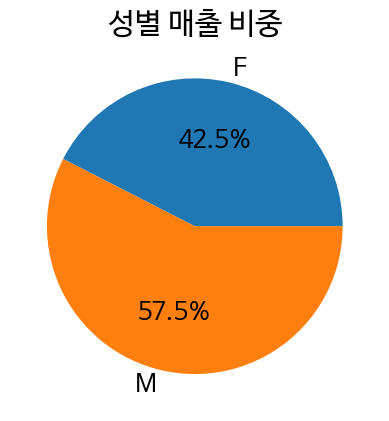

In [14]:
# 현재의 인구를 기준으로 분석할 것이기 때문에 2025년 데이터를 따로 불러온다.
df_2025 = pd.read_csv('data/external/sampled_2025.csv', usecols=['age', 'sex', 'amt', 'cnt', 'card_tpbuz_cd'])

# 1. 성별 매출 비중
sex_amt = df_2025.groupby('sex')['amt'].sum()
plt.pie(sex_amt, labels=sex_amt.index, autopct='%.1f%%')
plt.title('성별 매출 비중')
plt.show()

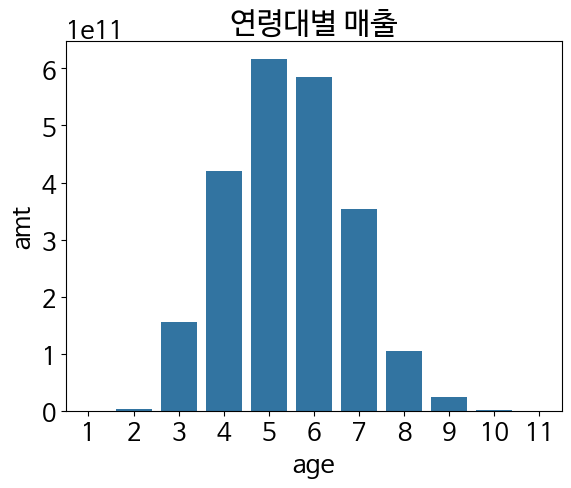

In [15]:
# 2. 연령대별 매출
age_amt = df_2025.groupby('age')['amt'].sum().reset_index()
sns.barplot(data=age_amt, x='age', y='amt')
plt.title('연령대별 매출')
plt.show()

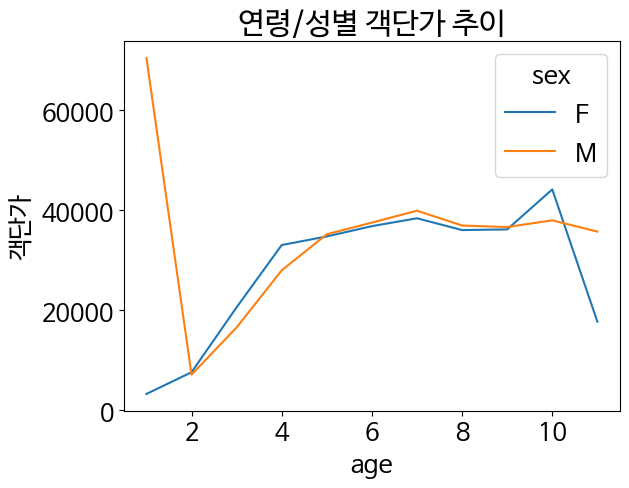

In [16]:
# 3. 객단가 분석
df_agg = df_2025.groupby(['age', 'sex'])[['amt', 'cnt']].sum().reset_index()
df_agg['객단가'] = df_agg['amt'] / df_agg['cnt']
sns.lineplot(data=df_agg, x='age', y='객단가', hue='sex')
plt.title('연령/성별 객단가 추이')
plt.show()

In [17]:
kid_df = df_2025[df_2025['age'] == 1]
kid_df['객단가'] = kid_df['amt'] / kid_df['cnt']
kid_male = kid_df[kid_df['sex'] == 'M']

stats = kid_df.groupby('sex')['객단가'].agg(['mean', 'median', 'count'])
print(stats)

top_biz = kid_male.groupby('card_tpbuz_cd')['amt'].sum().nlargest(5)
print("매출 주도 업종:", top_biz)

top_trans = kid_male.nlargest(5, '객단가')
print("최고액 거래 내역:", top_trans)

             mean  median  count
sex                             
F     3444.260870  2065.5     23
M    72890.147059  6513.5     17
매출 주도 업종: card_tpbuz_cd
S03    2093042
D11     198358
Q02      99786
F09      93240
Q05      32074
Name: amt, dtype: int64
최고액 거래 내역:         card_tpbuz_cd sex  age      amt  cnt        객단가
925323            S03   M    1  2093042    2  1046521.0
649843            Q02   M    1    99786    2    49893.0
1021318           F09   M    1    93240    2    46620.0
831593            D11   M    1   118966    4    29741.5
2202465           D11   M    1    19430    2     9715.0


분석 포인트

- 핵심 소비층 : 매출 총액이 가장 큰 연령대
- 미래 소비층 : 2030세대의 비중
- 남성 여성의 소비 패턴 차이
- 1회 결제금액이 가장 높은 집단

## Step 4. 카테고리 분석